In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed, Input
from tensorflow.keras import backend as K
import numpy as np
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("../main datasets/feature_engineered_dataset.csv")

In [4]:
import joblib
le = joblib.load("../encoder/city_encoder.joblib")

In [5]:
df['city_encoded'] = le.transform(df['city'])

In [6]:
TARGET_COL = "us_aqi"

In [90]:
def calculate_permutation_importance(model, X_test, y_test, feature_names):
    """
    Calculates feature importance using the permutation method.
    """
    print("Calculating baseline performance...")
    # 1. Calculate baseline performance
    baseline_preds = model.predict(X_test, verbose=0).flatten()
    baseline_mae = mean_absolute_error(y_test, baseline_preds)
    print(f"Baseline Test MAE: {baseline_mae:.4f}")
    
    importances = {}
    
    # 2. Iterate through each feature
    for i, name in enumerate(feature_names):
        print(f"Shuffling feature: {name} ({i+1}/{len(feature_names)})...")
        
        X_test_permuted = X_test.copy()
        
        # Shuffle the i-th feature column
        np.random.shuffle(X_test_permuted[:, :, i])
        
        # 3. Make predictions with the permuted data
        permuted_preds = model.predict(X_test_permuted, verbose=0).flatten()
        
        # 4. Calculate the new MAE
        permuted_mae = mean_absolute_error(y_test, permuted_preds)
        
        # 5. Store the increase in error as the importance score
        importances[name] = permuted_mae - baseline_mae
        
    return importances

Calculating baseline performance...
Baseline Test MAE: 11.7235
Shuffling feature: pm10 (1/16)...
Shuffling feature: pm2_5 (2/16)...
Shuffling feature: carbon_monoxide (3/16)...
Shuffling feature: nitrogen_dioxide (4/16)...
Shuffling feature: sulphur_dioxide (5/16)...
Shuffling feature: ozone (6/16)...
Shuffling feature: uv_index_clear_sky (7/16)...
Shuffling feature: dust (8/16)...
Shuffling feature: aerosol_optical_depth (9/16)...
Shuffling feature: hour_sin (10/16)...
Shuffling feature: hour_cos (11/16)...
Shuffling feature: month_sin (12/16)...
Shuffling feature: month_cos (13/16)...
Shuffling feature: day_of_week (14/16)...
Shuffling feature: year (15/16)...
Shuffling feature: city_encoded (16/16)...

--- Plotting Feature Importance ---


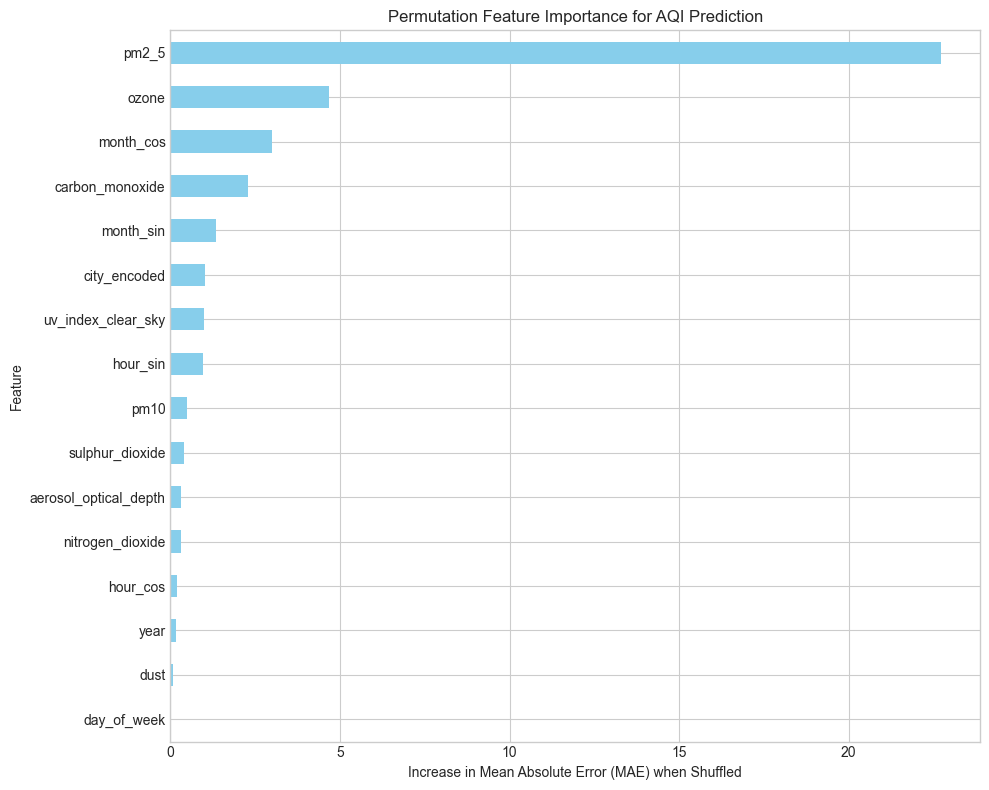

In [91]:
# Calculate the importance scores
importance_scores = calculate_permutation_importance(model1, X_test_reshaped, y_test, feature_names=X.columns.to_list())

# Convert to a pandas Series for easy sorting and plotting
importance_series = pd.Series(importance_scores).sort_values(ascending=True)

# Plot the results
print("\n--- Plotting Feature Importance ---")
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 8))
importance_series.plot(kind='barh', ax=ax, color='skyblue')
ax.set_title('Permutation Feature Importance for AQI Prediction')
ax.set_xlabel('Increase in Mean Absolute Error (MAE) when Shuffled')
ax.set_ylabel('Feature')
plt.tight_layout()
plt.show()

### X, y without uv_index, day_of_week, dust

In [12]:
DROPPED_COLUMNS = ["uv_index", "day_of_week", "dust"]

In [13]:
X = df[[col for col in df.columns if col not in ["date", "city", TARGET_COL]+DROPPED_COLUMNS]]
y = df[TARGET_COL]

In [14]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=43)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=43)

In [15]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (42352, 15)
y_train shape: (42352,)
X_val shape: (10589, 15)
y_val shape: (10589,)
X_test shape: (5883, 15)
y_test shape: (5883,)


In [16]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [31]:
import joblib
joblib.dump(scaler, "../encoder/model_scaler.joblib")

['../encoder/model_scaler.joblib']

In [17]:
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_reshaped = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [18]:
print(f"X_train_reshaped shape: {X_train_reshaped.shape}")
print(f"X_val_reshaped shape: {X_val_reshaped.shape}")
print(f"X_test_reshaped shape: {X_test_reshaped.shape}")

X_train_reshaped shape: (42352, 1, 15)
X_val_reshaped shape: (10589, 1, 15)
X_test_reshaped shape: (5883, 1, 15)


In [19]:
def build_mlp_lstm_model(input_shape):
    model = Sequential(name="MLP_LSTM_Hybrid_Model")
    model.add(Input(shape=input_shape))
    model.add(TimeDistributed(Dense(10, activation='relu')))
    model.add(TimeDistributed(Dense(5, activation='relu')))
    model.add(TimeDistributed(Dense(1, activation='relu')))
    model.add(LSTM(128, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1))
    return model

In [20]:
n_features = X_train_reshaped.shape[2]
input_shape = (1, n_features)

In [21]:
model1 = build_mlp_lstm_model(input_shape=input_shape)

In [22]:
def r_squared(y_true, y_pred):
    """
    Calculates the R-squared (coefficient of determination) metric.
    """
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res / (SS_tot + K.epsilon()))

In [23]:
model1.compile(optimizer="adam", loss="mean_squared_error", metrics=[
        'mean_squared_error',
        tf.keras.metrics.RootMeanSquaredError(name='rmse'),
        r_squared,
        'mae',
        'mape',
    ])

In [24]:
print("--- Model Summary ---")
model1.summary()
print("-" * 30)

--- Model Summary ---


Model: "MLP_LSTM_Hybrid_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 1, 10)          │           160 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 1, 5)           │            55 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 1, 1)           │             6 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │        12,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,782 (311.65 KB)

 Trainable params: 79,782 (311.65 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------


In [32]:
X_train_reshaped.shape

(42352, 1, 15)

In [25]:
print("--- Starting Model Training ---")
history1 = model1.fit(
    X_train_reshaped,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_reshaped, y_val),
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)
print("--- Model Training Finished ---")
print("-" * 30)

--- Starting Model Training ---
Epoch 1/50
1324/1324 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1348.5698 - mae: 23.1724 - mape: 28.8263 - mean_squared_error: 1348.5698 - r_squared: 0.4043 - rmse: 36.7229 - val_loss: 345.7149 - val_mae: 14.0282 - val_mape: 18.1920 - val_mean_squared_error: 345.7149 - val_r_squared: 0.8432 - val_rmse: 18.5934
Epoch 2/50
1324/1324 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 313.1413 - mae: 13.2806 - mape: 16.7919 - mean_squared_error: 313.1413 - r_squared: 0.8594 - rmse: 17.6958 - val_loss: 298.7246 - val_mae: 12.9803 - val_mape: 16.7783 - val_mean_squared_error: 298.7246 - val_r_squared: 0.8641 - val_rmse: 17.2837
Epoch 3/50
1324/1324 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 288.1120 - mae: 12.5932 - mape: 15.7292 - mean_squared_error: 288.1120 - r_squared: 0.8704 - rmse: 16.9739 - val_loss: 294.9879 - val_mae: 12.7507 - val_mape: 15.2820 - val_mean_squared_error: 294.9879 - val_r_squared: 0.8664 - val_rmse: 17.1752
Epoch 4/50
1324/1324 ━━━━━━━━━━━━━━━━━━━━ 

In [26]:
print("--- Evaluating Model on Test Set ---")
results = model1.evaluate(X_test_reshaped, y_test, verbose=1)
results = [round(result, 2) for result in results]
print(f"Test Loss (MSE): {results[1]}")
print(f"Test Root Mean Squared Error (RMSE): {results[2]}")
print(f"Test R-squared: {results[3]}")
print(f"Test Mean Absolute Error (MAE): {results[4]}")
print(f"Test Mean Absolute Percentage Error (MAPE): {results[5]} %")
print("-" * 30)

--- Evaluating Model on Test Set ---
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 238.3841 - mae: 11.1546 - mape: 13.8364 - mean_squared_error: 238.3841 - r_squared: 0.8912 - rmse: 15.4397
Test Loss (MSE): 238.38
Test Root Mean Squared Error (RMSE): 15.44
Test R-squared: 0.89
Test Mean Absolute Error (MAE): 11.15
Test Mean Absolute Percentage Error (MAPE): 13.84 %
------------------------------


184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
--- Plotting Actual vs. Predicted Values ---


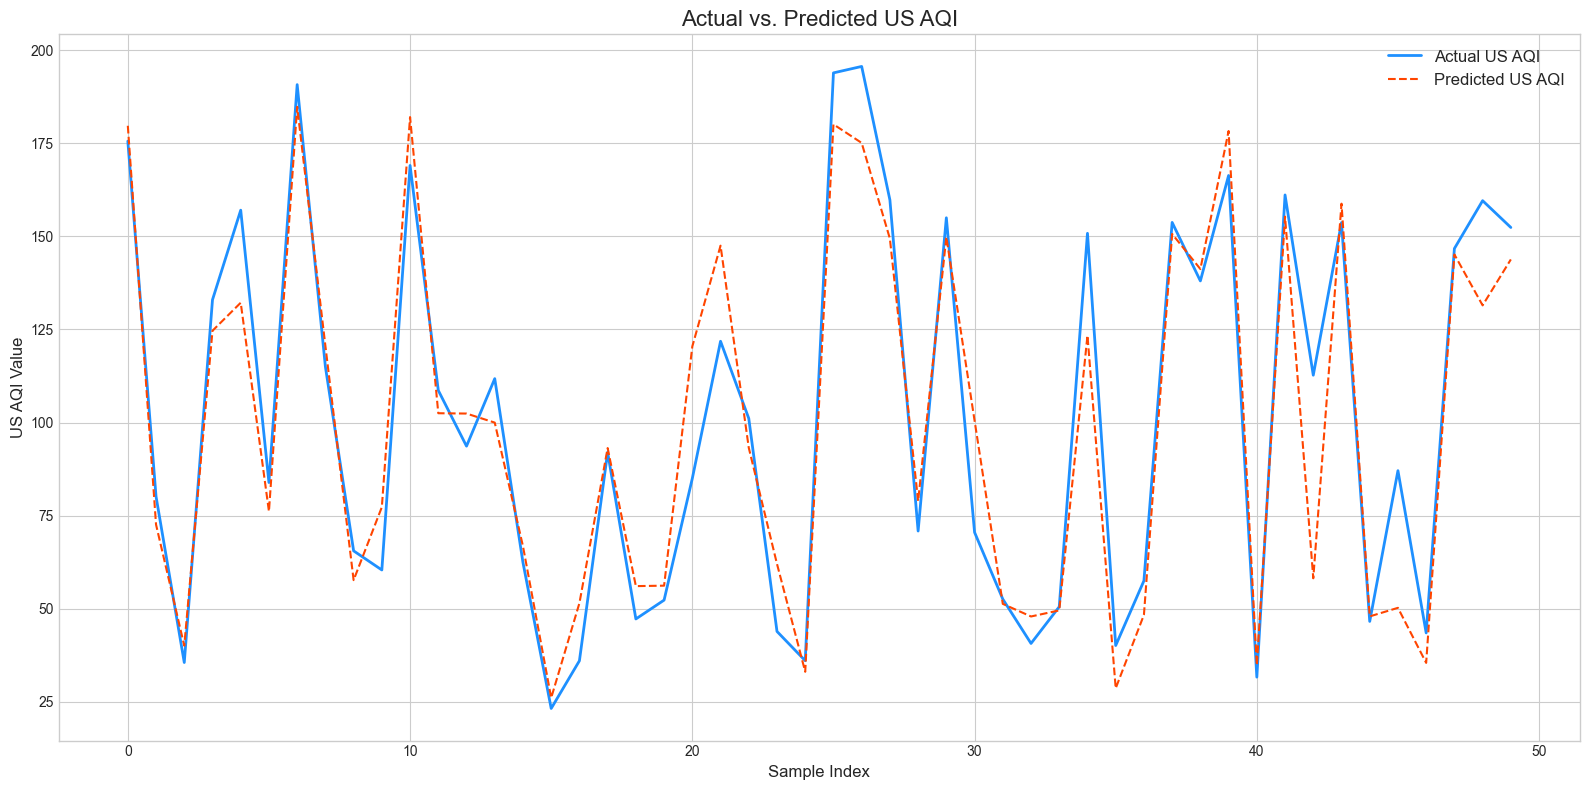

In [27]:
y_pred = model1.predict(X_test_reshaped).flatten()
print("--- Plotting Actual vs. Predicted Values ---")
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(16, 8))

sample_size = 50
actual_sample = y_test.iloc[:sample_size].values
predicted_sample = y_pred[:sample_size]

plt.plot(actual_sample, label='Actual US AQI', color='dodgerblue', linewidth=2)
plt.plot(predicted_sample, label='Predicted US AQI', color='orangered', linestyle='--')

plt.title(f'Actual vs. Predicted US AQI', fontsize=16)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('US AQI Value', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

--- Plotting Training History for All Metrics ---


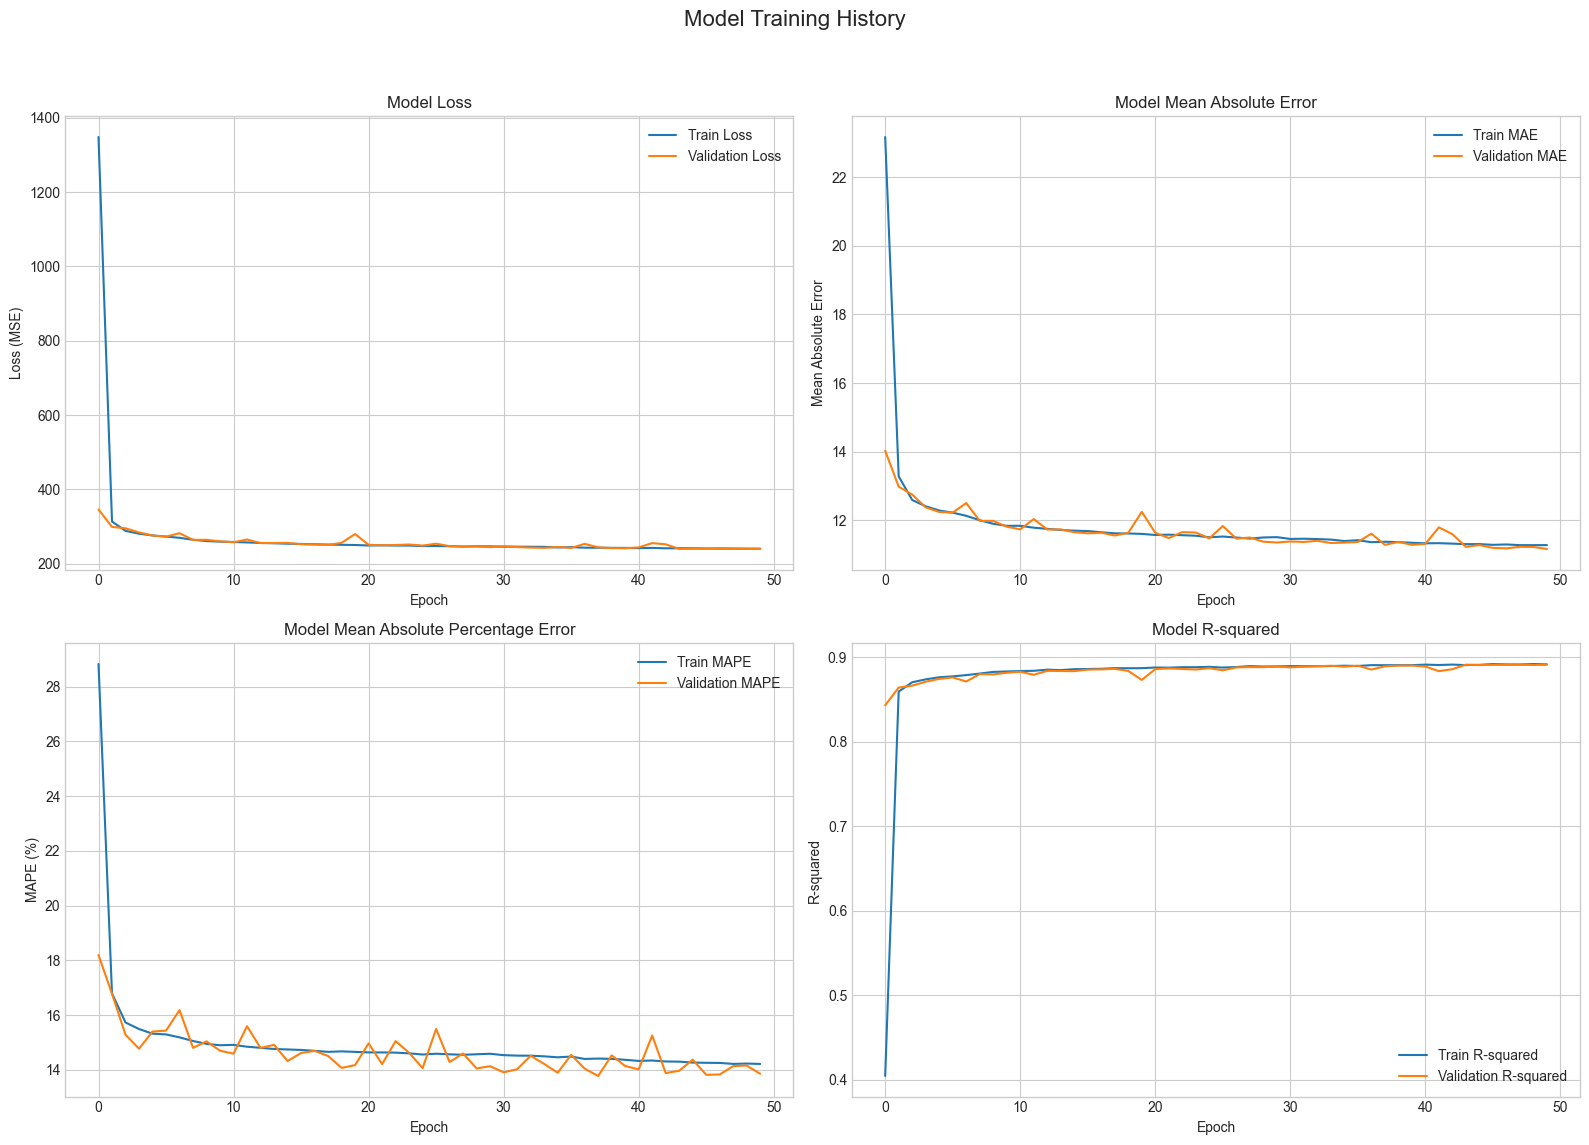

In [28]:
print("--- Plotting Training History for All Metrics ---")

# Create a figure with a 2x2 grid of subplots
fig, ax = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Training History', fontsize=16)

# --- Plot 1: Model Loss (MSE) ---
ax[0, 0].plot(history1.history['loss'], label='Train Loss')
ax[0, 0].plot(history1.history['val_loss'], label='Validation Loss')
ax[0, 0].set_title('Model Loss')
ax[0, 0].set_ylabel('Loss (MSE)')
ax[0, 0].set_xlabel('Epoch')
ax[0, 0].legend(loc='upper right')
ax[0, 0].grid(True)

# --- Plot 2: Mean Absolute Error (MAE) ---
ax[0, 1].plot(history1.history['mae'], label='Train MAE')
ax[0, 1].plot(history1.history['val_mae'], label='Validation MAE')
ax[0, 1].set_title('Model Mean Absolute Error')
ax[0, 1].set_ylabel('Mean Absolute Error')
ax[0, 1].set_xlabel('Epoch')
ax[0, 1].legend(loc='upper right')
ax[0, 1].grid(True)

# --- Plot 3: Mean Absolute Percentage Error (MAPE) ---
# Note: The key might be 'mean_absolute_percentage_error' or 'mape'
# depending on your TensorFlow version. Check history.history.keys() if you get an error.
mape_key = 'mape' if 'mape' in history1.history else 'mean_absolute_percentage_error'
val_mape_key = 'val_mape' if 'val_mape' in history1.history else 'val_mean_absolute_percentage_error'

ax[1, 0].plot(history1.history[mape_key], label='Train MAPE')
ax[1, 0].plot(history1.history[val_mape_key], label='Validation MAPE')
ax[1, 0].set_title('Model Mean Absolute Percentage Error')
ax[1, 0].set_ylabel('MAPE (%)')
ax[1, 0].set_xlabel('Epoch')
ax[1, 0].legend(loc='upper right')
ax[1, 0].grid(True)

# --- Plot 4: R-squared ---
ax[1, 1].plot(history1.history['r_squared'], label='Train R-squared')
ax[1, 1].plot(history1.history['val_r_squared'], label='Validation R-squared')
ax[1, 1].set_title('Model R-squared')
ax[1, 1].set_ylabel('R-squared')
ax[1, 1].set_xlabel('Epoch')
ax[1, 1].legend(loc='lower right') # Lower right is often better for R²
ax[1, 1].grid(True)

# Adjust layout to prevent plots from overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [29]:
model1.save('../models/mlp_lstm_model.keras')

In [30]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

# 1. Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse:.2f}")

# 2. Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# 3. R-squared (R²)
r2 = r2_score(y_test, y_pred)
print(f"R-squared (R²): {r2:.2f}")

# 4. Mean Absolute Error (MAE) - NEW
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# 5. Mean Absolute Percentage Error (MAPE) - NEW
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2%}") # Formats as a percentage

Mean Squared Error (MSE): 238.38
Root Mean Squared Error (RMSE): 15.44
R-squared (R²): 0.90
Mean Absolute Error (MAE): 11.15
Mean Absolute Percentage Error (MAPE): 13.84%
